In [10]:
library(dplyr)
library(lubridate)
library(R.matlab)
library(tidyr)
library(tibble)
library(rdbnomics)
library(magrittr)
library(ggplot2)

In [11]:
gdp_values <- rdb(ids="INSEE/CNT-2010-PIB-EQB-RF/T.CNT-EQUILIBRE_PIB.SO.PIB.SO.VALEUR_ABSOLUE.FE.V.EUROS.CVS-CJO") %>%
add_column(var="gdp_values")

In [12]:
expenditures_values <-
rdb(ids="INSEE/CNT-2010-CSI/T.CNT-OPERATIONS_SECTEURS_INST.S13.E.OTE.VALEUR_ABSOLUE.FE.EUROS.CVS-CJO") %>%
add_column(var="expenditures_values")

In [13]:
debt_gdp <-
rdb(ids="INSEE/DETTE-TRIM-APU/T.DETTE_MAASTRICHT.S13.F.PROPORTION.FE.POURCENT.BRUT.SO") %>%
add_column(var="debt_gdp") %>%
mutate(value=value/100)

In [14]:
rawdata <-
bind_rows(gdp_values,expenditures_values,debt_gdp) %>%
select(period,value,var) %>%
spread(var,value) %>%
mutate(expenditures_gdp=expenditures_values/gdp_values) %>%
select(period,expenditures_gdp,debt_gdp) %>%
filter(year(period)>=1996 & year(period)<=2017) %>%
mutate(period=paste(year(period),quarter(period),sep="Q"))

colnames(rawdata)[1] <- ""

In [15]:
head(rawdata)

,expenditures_gdp,debt_gdp
1996Q1,0.5481676,0.572
1996Q2,0.5469781,0.582
1996Q3,0.5479211,0.592
1996Q4,0.5501478,0.600
1997Q1,0.5522373,0.603
1997Q2,0.5480297,0.623


In [16]:
write.csv(rawdata,"data.csv",row.names = F)

In [ ]:
colnames(rawdata)[1] <- "period"
rawdata %<>% add_column(measure="raw data")

In [17]:
system2(
    'octave',
    args = c('--eval', '"addpath /usr/local/lib/dynare/matlab/; dynare model.mod"', '--no-window-system'),
    stdout = "stdout.txt",
    stderr = "stderr.txt",
    stdin = "",
    input = NULL,
    env = character(),
    wait = TRUE,
)
# The output of this command is written in files `stderr.txt` and `stdout.txt`.

# Dynare use the model `model.mod` and generate the files beginning with `model`.

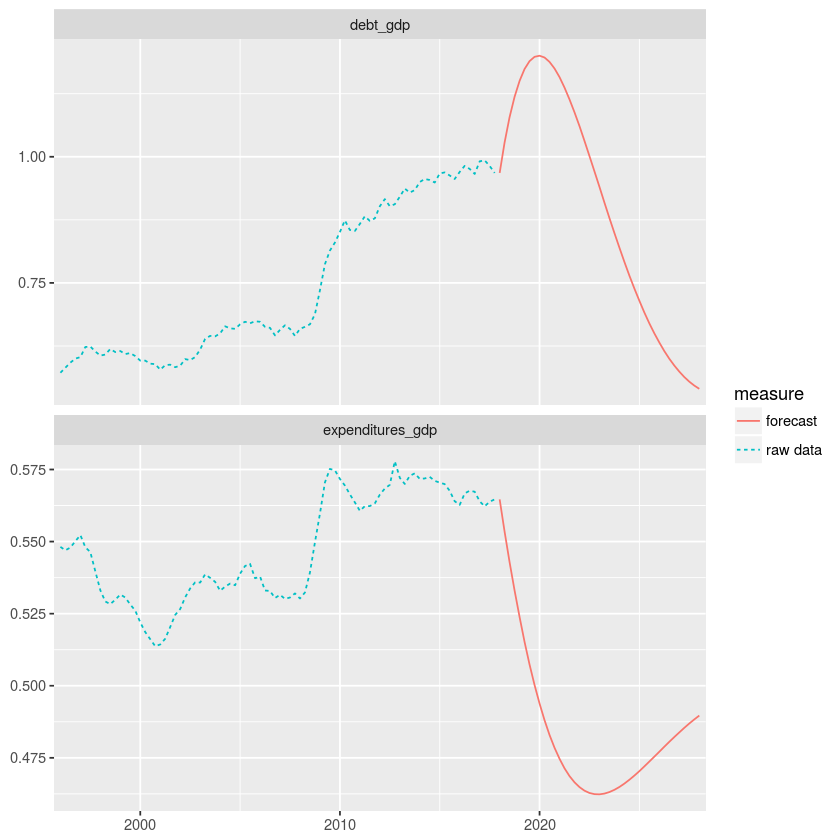

In [20]:
simuldata <- readMat("simuldata.mat",fixNames = F)
simuldatatime <- readMat("simuldatatime.mat",fixNames = F)

data <- data.frame(simuldata[[1]][1])
name <- unlist(simuldata[[1]][[3]])
colnames(data) <- name
period <- 
  as.data.frame(simuldatatime[[1]][[2]]) %>% 
  unite(period,c(V1,V2),sep="Q")

simuldata2 <-
  data %>% 
  mutate(period=period$period) %>% 
  select(period,expenditures_gdp=expt,debt_gdp=dt) %>% 
  add_column(measure="forecast")

df <- 
  bind_rows(simuldata2,rawdata) %>% 
  gather(var,value,-measure,-period) %>% 
  arrange(var,period) %>% 
  mutate(period=yq(period))

ggplot(df,aes(period,value,linetype=measure,colour=measure))+
  geom_line()+
  facet_wrap(~var,ncol=1,scales="free_y")+
  scale_x_date(expand = c(0.01,0.01)) +
  xlab(NULL) + ylab(NULL)